**CLNPricing**  
*   Curve construction (Credit, SOFR, LIBOR)
*   Volatility surface construction (for calibration use)
*   Parameters calibration (mean reversion, sigma) 
*   Pricing Engine (CDS+FRN)


**First Step : Curve Construction**

In [120]:
import QuantLib as ql 
import datetime 
import numpy as np 
import matplotlib.pyplot as py 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 
py.style.use('seaborn')
import pandas as pd 
import re
from scipy.interpolate import interp2d
from collections import namedtuple 
import math

C:\Users\10830\AppData\Local\Temp\ipykernel_36184\329312178.py:8: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



SOFR Term Structure (for discounting)

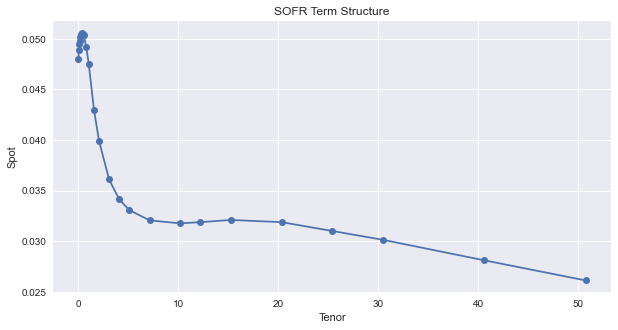

In [121]:
# Deposiot rates 
depo_maturities = [ql.Period(1, ql.Days)] 
depo_rates = [0.048] 

#Swap rates 
swap_maturities = [ql.Period('1W'), ql.Period('2W'), ql.Period('1M'), ql.Period('2M'), ql.Period('3M'), ql.Period('4M'), ql.Period('5M'), ql.Period('6M'), ql.Period('9M'),
                   ql.Period('1Y'), ql.Period('18M'), ql.Period('2Y'), ql.Period('3Y'), ql.Period('4Y'), ql.Period('5Y'), ql.Period('7Y'), ql.Period('10Y'), ql.Period('12Y'),
                   ql.Period('15Y'), ql.Period('20Y'), ql.Period('25Y'), ql.Period('30Y'), ql.Period('40Y'), ql.Period('50Y')]

swap_rates = [0.049092, 0.049611, 0.049937, 0.050311, 0.050538, 0.050608, 0.050586, 0.050444, 0.049234, 0.047517, 0.043081, 0.03997,
              0.03611, 0.03411, 0.03306, 0.03205, 0.03176, 0.03188, 0.0321, 0.031887, 0.03102, 0.03015, 0.02813, 0.02615]

# set evaluation date
calc_date = ql.Date(27, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date 

# Cash rate helper 
# we build a helper for every rate, setting its calendar, day count convention......
depo_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100)), m, 0, ql.UnitedStates(ql.UnitedStates.NYSE),
                                     ql.ModifiedFollowing, False, ql.Actual360())
                                     for r,m in zip(depo_rates, depo_maturities)]

# OIS Swap rate helper 
# can't skip parameters, declare it type even if not going to assign value to it 
swap_helpers = [] 
for r, m in zip(swap_rates, swap_maturities):
    helper = ql.OISRateHelper(settlementDays = 2,
                              tenor = m,
                              rate = ql.QuoteHandle(ql.SimpleQuote(r/100)),
                              index = ql.OvernightIndex('OIS', 1, ql.USDCurrency(),
                                                        ql.UnitedStates(ql.UnitedStates.NYSE),ql.Actual360()),
                              discountingCurve = ql.YieldTermStructureHandle(),
                              paymentLag = 2,
                              paymentConvention = ql.ModifiedFollowing,
                              paymentFrequency = ql.Annual,
                              paymentCalendar = ql.UnitedStates(ql.UnitedStates.NYSE)
                              )
    swap_helpers.append(helper) 

# combine helpers and implement interpolation 
rate_helpers = depo_helpers + swap_helpers 
sofrCurve =ql.PiecewiseLinearZero(calc_date, rate_helpers, ql.Actual360())

# visualization 
spots = [] 
tenors = [] 
for d in sofrCurve.dates():
    if d!=calc_date:
        yrs = ql.Actual360().yearFraction(calc_date, d)
        compounding = ql.Continuous 
        freq = ql.NoFrequency
        zero_rate = sofrCurve.zeroRate(yrs, compounding, freq) 
        tenors.append(yrs) 
        eq_rate = zero_rate.equivalentRate(ql.Actual360(), compounding, freq, calc_date, d).rate() 
        spots.append(100*eq_rate)

py.figure(figsize=(10,5))
py.plot(tenors, spots, marker='o') 
py.title('SOFR Term Structure')
py.xlabel('Tenor')
py.ylabel('Spot')
py.show()



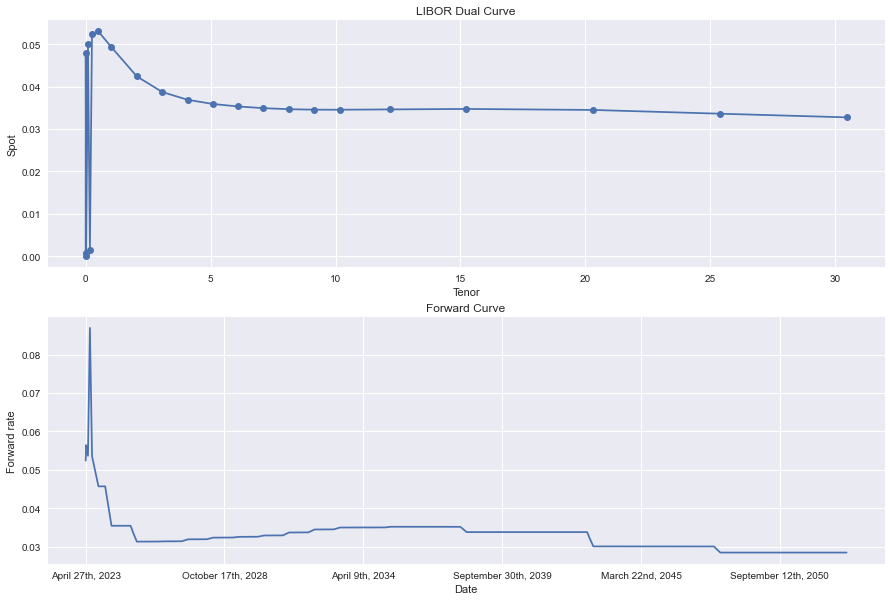

In [122]:
# Deposit rates 
depo_maturities = [ql.Period('1D'), ql.Period('1W'), ql.Period('1M'), ql.Period('2M'), ql.Period('3M'), ql.Period('6M')] 
depo_rates = [0.0479571, 0.0007638, 0.0502457, 0.001525, 0.0527271, 0.0537186]

# Swap rates 
swap_maturities  = [ql.Period('1Y'), ql.Period('2Y'), ql.Period('3Y'), ql.Period('4Y'), ql.Period('5Y'), ql.Period('6Y'), ql.Period('7Y'),
                    ql.Period('8Y'), ql.Period('9Y'), ql.Period('10Y'), ql.Period('12Y'), ql.Period('15Y'), ql.Period('20Y'),
                    ql.Period('25Y'), ql.Period('30Y')]

swap_rates = [0.05107, 0.04357, 0.03975, 0.03777, 0.03669, 0.03606, 0.03564, 0.03537, 0.03528, 0.03525, 0.0353, 0.03542, 0.03517,
              0.03426, 0.03337]

# set evaluation date 
calc_date = ql.Date(27, 4, 2023) 
ql.Settings.instance().evaluationDate = calc_date 

# Cash rate helper 
depo_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r)), m, 0, ql.UnitedKingdom(),
                                     ql.ModifiedFollowing, True, ql.Actual360())
                                     for r, m in zip(depo_rates, depo_maturities)]

# Swap rate helper 
swap_helpers = [] 
for r, m in zip(swap_rates, swap_maturities):
    helper = ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(r)),
                               m,
                               ql.UnitedKingdom(),
                               ql.Semiannual,
                               ql.ModifiedFollowing,
                               ql.ActualActual(ql.UnitedStates.NYSE),
                               ql.USDLibor(ql.Period(3, ql.Months)),
                               ql.QuoteHandle(),
                               ql.Period(),
                               ql.YieldTermStructureHandle(sofrCurve))
    swap_helpers.append(helper) 

# combine rate helpers and implement interpolation 
rate_helpers = depo_helpers + swap_helpers 
liborCurve = ql.PiecewiseLogLinearDiscount(calc_date, rate_helpers, ql.Actual360())
liborCurve.enableExtrapolation() # avoid the situation which the maturity of swaption is larger than that of curve while conducting calibration

# get forward rate 
forwardCurveDate = [] 
start_date = liborCurve.dates()[0]
while (start_date<liborCurve.dates()[-1]):
    forwardCurveDate.append(start_date) 
    start_date = start_date + ql.Period(1, ql.Days)

forwardRate = []
for d in forwardCurveDate:
    forwardRate.append(liborCurve.forwardRate(d,d+ql.Period('3M'),ql.Actual360(),ql.Continuous,ql.Quarterly,True).rate())

# construct forward curve 
forwardCurve = ql.ForwardCurve(forwardCurveDate, forwardRate, ql.Actual360(), ql.TARGET())
forwardCurve.enableExtrapolation()

# visualization 
spots = [] 
tenors = [] 
for d in liborCurve.dates():
    yrs = ql.Actual360().yearFraction(calc_date, d)
    compounding = ql.Continuous
    freq = ql.NoFrequency
    zero_rate = liborCurve.zeroRate(yrs, compounding, freq)
    tenors.append(yrs) 
    eq_rate = zero_rate.equivalentRate(ql.Actual360(), compounding, freq, calc_date, d).rate()
    spots.append(eq_rate)

forwardData = pd.DataFrame({'Rate':forwardRate}, index=forwardCurveDate)
py.figure(figsize=(15,10))
py.tight_layout()
py.subplot(2,1,1)
py.plot(tenors, spots, marker='o') 
py.xlabel('Tenor')
py.ylabel('Spot')
py.title('LIBOR Dual Curve')
py.subplot(2,1,2)
forwardData['Rate'].plot() 
py.xlabel('Date')
py.ylabel('Forward rate')
py.title('Forward Curve')
py.show()

Credit Curve

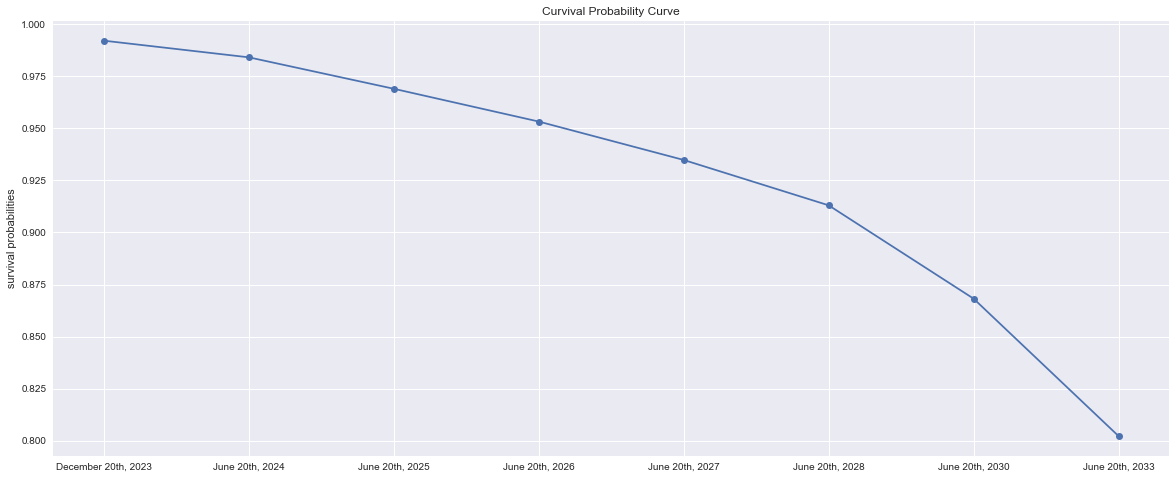

In [123]:
cds_tenor = [ql.Period(6, ql.Months), ql.Period(1, ql.Years), ql.Period(2, ql.Years), ql.Period(3, ql.Years), ql.Period(4, ql.Years), ql.Period(5, ql.Years),
                  ql.Period(7, ql.Years), ql.Period(10, ql.Years)]

cds_spread = [71.75, 82.12, 86.48, 89.77, 95.86, 103.98, 115.9, 126.75] # initial value times 100000

# basic settings 
recoveryRate = 0.4 
today = ql.Date(27, 4, 2023) 
settlementDate = ql.Date(2, 5, 2023)

# set CDS helper
CDSHelper = [ql.SpreadCdsHelper((spread/10000.0), tenor, 0, ql.TARGET(), ql.Quarterly, ql.Following,
             ql.DateGeneration.TwentiethIMM, ql.Actual360(), recoveryRate, ql.YieldTermStructureHandle(sofrCurve))
             for spread, tenor in zip(cds_spread, cds_tenor)]

def years_between_dates(start_date, end_date):
    day_count = ql.Actual360()
    years = day_count.yearFraction(start_date, end_date)
    
    return round(years,6)

# construct hazard rate curve 
pd_curve = ql.PiecewiseFlatHazardRate(settlementDate, CDSHelper, ql.Thirty360(ql.Thirty360.USA))

# derive survival probability from hazard rate
dates = [ql.Date(20, 12, 2023), ql.Date(20, 6, 2024), ql.Date(20, 6, 2025), ql.Date(20, 6, 2026), ql.Date(20, 6, 2027), ql.Date(20, 6, 2028), ql.Date(20, 6, 2030), ql.Date(20, 6, 2033)]
yrs = [years_between_dates(ql.Date(27,4,2023), x) for x in dates]
spNumerix = [0.99221145, 0.98421562, 0.96913124, 0.95337462, 0.93477870, 0.91262887, 0.86688177, 0.79921164]
spQuantlib = []
hrQuantlib = []
for d in dates:
    #hrQuantlib.append(pd_curve.hazardRate(d))
    spQuantlib.append(pd_curve.survivalProbability(d))

# visualization 
sp = pd.DataFrame({'SP':spQuantlib},index=dates)
py.figure(figsize=(20,8))
sp['SP'].plot(marker='o')
py.ylabel('survival probabilities')
py.title('Curvival Probability Curve')
py.show()

**Second step : Construct volatility surface**  

In [124]:
# define a function that extract option tenor and swap tenor from quotes 
def extract_num(cell):
    if 'M' in cell: # if unit is month
        res = int(re.findall(r'\d+', cell)[0]) / 12 # transform to unit year 
    else:
        res = int(re.findall(r'\d+', cell)[0])
    return res

In [125]:
df = pd.read_csv("C:\\Users\\10830\\Desktop\\學校\\碩一上\\Quantlib\\E.sun Structural Bond Pricing\\Data\\20230427.csv")
df.rename(columns={'Taipei_official_marketdata_Env_0':'Value'}, inplace=True) 

# select market quote of swaptions (in normal vol) 
prefix_length = 33 
prefix = df['Name'].str[:prefix_length]
filter = (prefix=='IR.USD-LIBOR-3M.VOL.SWPT.RLTV.ATM')
volQuote = pd.DataFrame(df[filter]).reset_index().dropna()

# add columns of option tenor and swap tenor 
volQuote['x'] = volQuote['Name'].str[35:37] # option tenor
volQuote['y'] = volQuote['Name'].str[38:42] # swap tenor  
volQuote['x'] = volQuote['x'].apply(extract_num)
volQuote['y'] = volQuote['y'].apply(extract_num)

# transform data to specific form in order to implement bilinear interpolation 
volQuote = volQuote.sort_values(by=['x', 'y'])
x = np.array([1/12, 1/6, 1/4, 1/2, 3/4, 1, 2, 3, 4, 5, 7, 10, 15, 20, 25])
y = np.array([1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30])
xx, yy = np.meshgrid(x, y)
z = np.zeros((11,15))

for x in range(0, 11):
    for y in range(0, 15):
        filter1 = (volQuote['x']==xx[x,y])
        filter2 = (volQuote['y']==yy[x,y])
        z[x,y] = volQuote[filter1][filter2]['Value'].values[0]

# volatility quote dataframe 
index = ['1M', '2M', '3M','6M', '9M', '1Y', '2Y', '3Y', '4Y', '5Y', '7Y', '10Y', '15Y', '20Y', '25Y'] 
columns = ['1Y', '2Y', '3Y', '4Y', '5Y', '7Y', '10Y', '15Y', '20Y', '25Y', '30Y']
volMatrix = pd.DataFrame(z.T, columns=columns, index=index)

# BiLinear Interpolation (from 1 month)
x1 = np.arange(1/12, 301/12, 1/12) 
y1 = np.arange(1, 361/12, 1/12) 
f = interp2d(xx, yy, z, kind='linear')
ZZ = f(x1, y1) 

# volatility quote dataframe (after interpolation)
volMatrix_interp = pd.DataFrame(ZZ.T, columns=y1, index=x1)

# visualization 
import plotly
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
pyo.init_notebook_mode()

vs_fig = go.Figure(data=[go.Surface(x=x1, y=y1, z=ZZ)])
vs_fig.update_layout(title='Surface', autosize=False, width=500, height=500, margin=dict(l=50, r=50, b=50, t=50))
vs_fig.update_layout(scene=dict(xaxis_title='expiry', yaxis_title='maturity', zaxis_title='volatility'))
vs_fig.show()

C:\Users\10830\AppData\Local\Temp\ipykernel_36184\4009364077.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



**Third Step : Model Calibration**

In [126]:
# basic settings 
today = ql.Date(27, 4, 2023) 
settlement = ql.Date(1, 5, 2023) 
ql.Settings.instance().evaluationDate = today 
termStructure = ql.YieldTermStructureHandle(liborCurve)
volQuote = volMatrix 
liborIndex = ql.USDLibor(ql.Period(3, ql.Months), termStructure)

# data processing 
calibrationData = namedtuple("calibrationData", "start, length, volatility")
data = [] 
for index in range(0,15):
    for column in range(0,11):
        data.append(calibrationData(volQuote.index[index],
                                    volQuote.columns[column], volQuote.to_numpy()[index, column]))

In [127]:
def create_swaption_helpers(data, index, term_structure, engine):
    swaptions = [] 
    fixed_leg_tenor = ql.Period(6, ql.Months) 
    fixed_leg_daycounter = ql.Thirty360(ql.Thirty360.European) 
    floating_leg_daycounter = ql.Actual360() 
    for d in data:
        vol_handle = ql.QuoteHandle(ql.SimpleQuote(d.volatility))
        helper = ql.SwaptionHelper(ql.Period(d.start),
                                   ql.Period(d.length),
                                   vol_handle,
                                   index,
                                   fixed_leg_tenor,
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   term_structure,
                                   ql.BlackCalibrationHelper.RelativePriceError, # relative price, price, relative volatility, volatility
                                   ql.nullDouble(),
                                   1.0,
                                   ql.Normal, # 這邊可以設定要用black model還是bachelier model 
                                   0.0
                                   )
        helper.setPricingEngine(engine) 
        swaptions.append(helper)
    
    return swaptions 

In [128]:
def calibration_report(swaptions, data):
    print("-"*82) 
    print("%15s %15s %15s %15s %15s" %("Model Price", "Market Price", "Implied Vol", "Market Vol",
                                       "Rel Error"))
    print("-"*82) 
    cum_err = 0.0
    for i, s in enumerate(swaptions):
        model_price = s.modelValue() 
        market_vol = data[i].volatility 
        black_price = s.blackPrice(market_vol) 
        rel_error = model_price/black_price - 1.0 
        implied_vol = s.impliedVolatility(model_price, 1e-5, 50, 0.0, 0.50) 
        rel_error2 = implied_vol/market_vol - 1.0 
        cum_err = cum_err + rel_error2*rel_error2 
        
        print("%15.5f %15.5f %15.5f %15.5f %15.5f" %(model_price, black_price, implied_vol, market_vol, rel_error))
    print("-"*82) 
    print("Cumulative Error : %15.5f" % math.sqrt(cum_err))

Method 1 : 全部報價拿來估計一組參數

In [129]:
model = ql.HullWhite(termStructure) # termStructure here represents LIBOR dual curve
engine = ql.JamshidianSwaptionEngine(model) 
swaptions = create_swaption_helpers(data, liborIndex, termStructure, engine)

optimization_method = ql.LevenbergMarquardt(1.0e-8, 1.0e-8, 1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(swaptions, optimization_method, end_criteria)

a, sigma = model.params() 
print("a = %6.5f, sigma = %6.5f" %(a, sigma))

a = 0.06953, sigma = 0.01485


Method 2 : 固定mean reversion，一個swaption跑一組參數(之後再寫)

In [28]:
# fixed reversion of 0.05 
# 拿option tenor + swap tenor = 15的swaption來做估計
constrained_model = ql.HullWhite(termStructure, 0.03, 0.01)
engine = ql.JamshidianSwaptionEngine(constrained_model) 
paramsList = []

interp_df = pd.DataFrame(ZZ.T, columns=y1.round(1), index=x1.round(1))
for i in [[1.0,14.0], [2.0,13.0], [3.0,12.0], [4.0,11.0], [5.0,10.0], [6.0,9.0], [7.0,8.0], 
          [8.0,7.0], [9.0,6.0], [10.0,5.0], [11.0,4.0], [12.0,3.0], [13.0,2.0], [14.0,1.0]]:
    fixed_leg_tenor = ql.Period(6, ql.Months) 
    fixed_leg_daycounter = ql.Thirty360(ql.Thirty360.European) 
    floating_leg_daycounter = ql.Actual360() 
    vol_handle = ql.QuoteHandle(ql.SimpleQuote(interp_df.loc[i[0], i[1]]))
    helper = ql.SwaptionHelper(ql.Period(int(i[0]), ql.Years),
                               ql.Period(int(i[1]), ql.Years),
                               vol_handle,
                               liborIndex,
                               fixed_leg_tenor,
                               fixed_leg_daycounter,
                               floating_leg_daycounter,
                               termStructure,
                               ql.BlackCalibrationHelper.RelativePriceError,
                               ql.nullDouble(),
                               1.0,
                               ql.Normal,
                               0.0
                               )
    helper.setPricingEngine(engine) 
    single_swaption = [helper] 
    optimization_method = ql.LevenbergMarquardt(1.0e-8, 1.0e-8, 1.0e-8)
    end_criteria = ql.EndCriteria(10000, 199, 1e-6, 1e-8, 1e-8) 
    constrained_model.calibrate(single_swaption, optimization_method, end_criteria, ql.NoConstraint(), [], [True, False])
    a, sigma = constrained_model.params() 
    paramsList.append([a, sigma])

paramsList 

[[0.03, 0.012207600153867482],
 [0.03, 0.011832586523689462],
 [0.03, 0.011423730687102942],
 [0.03, 0.011035215036442938],
 [0.03, 0.010803473098848186],
 [0.03, 0.01061785162447133],
 [0.03, 0.010381444216073506],
 [0.03, 0.01019264948870439],
 [0.03, 0.009984769116696138],
 [0.03, 0.009737878028465414],
 [0.03, 0.009621516530480156],
 [0.03, 0.009523939365919715],
 [0.03, 0.009461254244526622],
 [0.03, 0.009337452980597568]]

**Fourth Step : Pricing Engine (By QuantLib)**

CDS Part

In [227]:
# 先建CDS instrument 
side = ql.Protection.Seller
nominal = 10000000 
spread = 0.0155
cdsSchedule = ql.MakeSchedule(ql.Date(20, 6, 2023), ql.Date(20, 6, 2024), ql.Period('3M'))
cds = ql.CreditDefaultSwap(side, nominal, spread, cdsSchedule, ql.Following, ql.Actual360())

# Pricing engine 
defaultProbability = ql.DefaultProbabilityTermStructureHandle(pd_curve)
yts = ql.YieldTermStructureHandle(sofrCurve)
recoveryRate = 0.4 
engine = ql.MidPointCdsEngine(defaultProbability, recoveryRate, yts)

cds.setPricingEngine(engine)
cdsPrice = cds.NPV()
cdsPrice 

71268.1031404385

FRN Part

In [229]:
# 建floating rate bond的instrument
schedule = ql.MakeSchedule(ql.Date(20, 6, 2023), ql.Date(20, 6, 2024), ql.Period('3M'))
index = ql.USDLibor(ql.Period(3, ql.Months), ql.YieldTermStructureHandle(liborCurve))
bond = ql.FloatingRateBond(2, 10000000, schedule, index, ql.Actual360(), spreads=[0])

# Pricing engine 
# model = ql.HullWhite(sofrCurve, a=0.06953, sigma=0.01485) 
engine = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(sofrCurve)) 
bond.setPricingEngine(engine) 
bondPrice = bond.NPV()
bondPrice 


RuntimeError: null term structure set to this instance of Euribor6M Actual/360

Combine

In [225]:
print('合約價值 ：',(bondPrice-cdsPrice)/100000)

合約價值 ： 104.6985937175983


**Testing Block**

In [ ]:
todays_date = ql.Date(10, ql.August, 2023)
end_date = todays_date + ql.Period(1, ql.Years)
steps = 12  # 一年有 12 个月

# 創建時間網格
time_grid = ql.TimeGrid(years_between_dates(ql.Date(27,4,2023),ql.Date(20,6,2024)), 420)

# 打印時間網格的時間點
for time in time_grid:
    print(time*360)
